Gym Environment with simpler car model for hyperparameter experimentation.

In [6]:
from gym import Env
from gym.spaces import Box
import numpy as np
import math
from pathlib import Path
import os

cwd = os.getcwd()
if os.path.basename(cwd) != "reinforcement-learning":
    os.chdir(Path(cwd).parents[1])
cwd = os.getcwd()
if os.path.basename(cwd) != "reinforcement-learning":
    print("Something went wrong. Restart Kernel and run again to be in base directory reinforcement-learning")
else:
    print("Directory checks out.")


class simpleDriver(Env):

    '''
    TODO Description

    The driver class runs in m/s.
    '''
    def __init__(self,

                ref_secs:list = [0, 2, 4, 5, 7, 10],
                ref_speeds: list = [0, 10, 20, 15, 20, 15],
                len_outlook: int = 1,
                num_act: int = 2, 
                v_Car_Init = None,

                reward_scale: float = 1
                ):

        '''
        Args:
        - ref_secs, list, used to generate a reference trajectory, contains second markers for reference speeds from ref_speeds
        - ref_speeds, list, used to generate a reference trajectory, contains reference speeds in km/h

        - len_outlook, int, how many future v_Soll values to use for the observation
        - v_car_init: float, initial speed of the car in km/h, if None is first reference speed ref_speeds[0]
        - reward_scale: float, linearly scale the reward: reward = reward_scale * reward_1 where reward_1 is the initial reward
        '''

        #Initializations
        self.ref_secs = ref_secs
        self.ref_speeds = ref_speeds
        self.len_outlook = len_outlook
        self.reward_scale = reward_scale

        #Normalization Bounds

        self.min_norm_obs = -1
        self.max_norm_obs = 1
        self.min_norm_act = -1
        self.max_norm_act =1
        self.v_Car_min = min(self.ref_speeds)
        self.v_Car_max = max(self.ref_speeds)
        self.DK_Soll_min = 0
        self.DK_Soll_max = 100
        self.Bremse_S_min = 0
        self.Bremse_S_max = 10

        # Initalization for Integration
        self.sim_stepsize = 0.01 # s
        self.vehicle_distance = 0 # m
        if v_Car_Init is None:
            self.v_Car_ms = self.ref_speeds[0] / 3.6
        else:
            self.v_Car_ms = v_Car_Init / 3.6
        
        #Validate Inputs
        self._validate()

        #Episode Length
        self.dtype = np.float32
        self.sim_duration = ref_secs[-1]
        self.episode_length = int(self.sim_duration / self.sim_stepsize)

        # load target velocities
        self.v_Soll_all = self._load_ref_trajectory()

        #Gym setup
        num_obs = self.len_outlook + 1
        self.observation_space = Box(low = np.repeat(self.min_norm_obs, num_obs), high = np.repeat(self.max_norm_obs, num_obs), shape = (num_obs,), dtype=self.dtype)

        # inputs: [DK_SOLL, Bremse], _normalized to [-1,1]
        self.action_space = Box(low = np.repeat(self.min_norm_act, num_act), high = np.repeat(self.max_norm_act, num_act), shape = (num_act,), dtype=self.dtype)

        #Add the first State
        v_Car_norm = self._normalize_2(value=self.v_Car_ms*3.6, min_val= self.v_Car_min, max_val= self.v_Car_max, min_norm=-1, max_norm=1)
        v_target = self.v_Soll_all[:self.len_outlook]
        v_target_norm = self._normalize_2(value=v_target, min_val= self.v_Car_min, max_val= self.v_Car_max, min_norm=-1, max_norm=1)
        deviation = (v_Car_norm - v_target_norm)/2 # divide by 2 to ensure the sum of two normalized numbers is in the normalization range
        self.first_state = np.append(v_Car_norm, deviation)
        self.state = self.first_state


        self.current_iteration = 0
        self.info = {}


    def _validate(self):

        '''
        Validates Inputs.
        '''

        errors = []
        warnings = []


        #Check Errors
        if len(self.ref_secs) != len(self.ref_speeds):
            error = f"Reference seconds has a different length than ref speeds. Length ref_secs: {len(self.ref_secs)}, length ref_speeds: {len(self.ref_speeds)}"
            errors.append(error)

        if self.ref_secs != self.ref_secs.sort():
            error = f"reference timestamps are not increasing. Reference Timestamps: {self.ref_secs}"



        #Check Warnings
        # No warnings to check in this environment

        if errors:
            print("Errors:\n")
            for error in errors:
                print(error)
            raise KeyError("See errors above.")

        if warnings:
            print("\nWarnings:\n")
            for warning in warnings:
                print(warning)


    def _reshape_to_length_n(self, array: np.array, length: int) -> np.array:
        '''
        Stretches a 1d numpy array to length n.
        '''
        len_array = len(array)
        array = np.append(array, np.repeat(array[-1], length - len_array))
        return(array)

    
    def _load_ref_trajectory(self) -> np.array:

        '''
        Loads a reference trajectory. See the notebook make_ref_trajectory for an example.
        '''
        ref_trajectory = np.array([])

        for idx in range(len(self.ref_secs)-1):
            sect_dur = self.ref_secs[idx+1] - self.ref_secs[idx]
            curr_speed = self.ref_speeds[idx]
            next_speed = self.ref_speeds[idx+1]
            num_steps = int(self.episode_length * sect_dur/self.sim_duration)

            section = np.linspace(curr_speed, next_speed, num_steps)
            ref_trajectory = np.append(ref_trajectory, section)

        return ref_trajectory


    def step(self, action):
        done = False

        # unnormalize the actions
        self.throttle = self._un_normalize_2(value = action[0], min_val = self.DK_Soll_min, max_val = self.DK_Soll_max, min_norm= -1, max_norm = 1)
        self.brake = self._un_normalize_2(value = action[1], min_val = self.Bremse_S_min, max_val = self.Bremse_S_max, min_norm= -1, max_norm = 1)

        #Take simple model step to action to calculate new car speed
        self._Car(self.throttle, self.brake)

        #Get current speed and normalize
        v_Car_norm = self._normalize_2(value = self.v_Car_kmh, min_val = self.v_Car_min, max_val = self.v_Car_max, min_norm = -1, max_norm = 1)

        #Get traget speed vector, normalize and calculate deviation
        len_outlook_iteration = np.min([self.episode_length - self.current_iteration, self.len_outlook]) #get future reference trajectory, shorted if we are at end of episode
        v_target = self.v_Soll_all[self.current_iteration:(self.current_iteration + len_outlook_iteration)]
        if len(v_target) != self.len_outlook:
            v_target = self._reshape_to_length_n(array=v_target, length=self.len_outlook)
        v_target_norm = self._normalize_2(value=v_target, min_val= self.v_Car_min, max_val= self.v_Car_max, min_norm= -1, max_norm= 1)
    
        deviation = (v_target_norm - v_Car_norm)/2 # divide by 2 to ensure the sum of two normalized numbers is in the normalization range
        obs = np.append(v_Car_norm, deviation)
       
        #Calculate Reward
        reward = -(np.abs(v_Car_norm - v_target_norm[0]).astype(float))
        reward = reward * self.reward_scale
                
        self.current_iteration += 1

        #Check if Round is done
        if self.current_iteration == self.episode_length:
            done = True       

        return obs, reward, done, self.info


    def _Car(self,
            throttle, brake) -> None:

        '''
        Takes a step with the car model.
        Args:
        - throttle in %
        - brake in m/s

        Influences:
        - self.v_Car_unnorm, the velocity of the car
        '''
        # parameters for the car
        vehicle_weight = 2500 # kg
        engine_power = 400000 # W
        engine_n_max_power = 6000 # upm
        engine_n_max = 22000 # upm
        gearbox_ratio = 8 # -
        tire_radius = 0.3 # m
        rho_air = 1.2 # kg/m³
        vehicle_cW = 0.25 # -
        vehicle_A = 2.2 # m²
        tire_fR = 0.01 # -
        g = 9.81 # m/s²

        #Air & Rolling Resistance in Newton     
        F_AirR = 1/2 * rho_air * vehicle_cW * vehicle_A * self.v_Car_ms**2 * np.sign(self.v_Car_ms)
        F_RR = vehicle_weight * tire_fR * g * np.sign(self.v_Car_ms)

        #Propulsion
        engine_speed = self.v_Car_ms / tire_radius / 2 / math.pi * 60 * gearbox_ratio
        if engine_speed < 0:
            engine_torque_ = 0
        elif (engine_speed >= 0) and (engine_speed < engine_n_max_power):
            engine_torque_ = throttle / 100 * engine_power / engine_n_max_power * 60 / 2 / math.pi
        elif (engine_speed > engine_n_max_power) and (engine_speed < engine_n_max):
            engine_torque_ = throttle / 100 * engine_power / engine_speed * 60 / 2 / math.pi
        elif engine_speed > engine_n_max:
            engine_torque_ = 0

        F_Prop = engine_torque_ * gearbox_ratio / tire_radius

        # Newton
        out_acceleration = ((F_Prop - F_RR - F_AirR) / vehicle_weight) - min(self.Bremse_S_max, brake)
        if (self.v_Car_ms <= 0.1) and (out_acceleration < 0): 
            out_acceleration = 0

        
        # Integrate
        self.v_Car_ms = self.v_Car_ms + self.sim_stepsize * out_acceleration
        self.v_Car_kmh = self.v_Car_ms * 3.6
        self.vehicle_distance = self.vehicle_distance + self.sim_stepsize * self.v_Car_ms            
    
    def _normalize_2 (self, value: float, min_val: float, max_val: float, min_norm: float, max_norm: float) -> float:
        '''
        normalizes a value to the [min_norm, max_norm] range
        Inverse of _normalize function

        Args:
        - value: the value to un_normalize
        - min_val: the minimum value in the allowed range of the value
        - max_val: the maximum value in the allowed range of the value
        - min_norm: lower boundary of the normalization range
        - max_norm: upper boundary of the normalization range
        '''
        val_norm = (value-min_val) * (max_norm - min_norm) / (max_val - min_val) + min_norm

        return(val_norm)

    def _un_normalize_2 (self, value: float, min_val: float, max_val: float, min_norm: float, max_norm: float) -> float:
        '''
        Un_normalizes a value from the [min_norm, max_norm] normalization
        Inverse of _normalize function

        Args:
        - value: the value to un_normalize
        - min_val: the minimum value in the allowed range of the value
        - max_val: the maximum value in the allowed range of the value
        - min_norm: lower boundary of the normalization range
        - max_norm: upper boundary of the normalization range
        '''
        unnorm_value = (value-min_norm) * (max_val - min_val) / (max_norm - min_norm) + min_val

        return(unnorm_value)
    
    def reset(self):

        #Reset Environment
        self.state = self.first_state
        self.current_iteration = 0

        return self.state

Directory checks out.


Train Agent using SAC

In [7]:
import os
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
import datetime
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback
from stable_baselines3.common.noise import NormalActionNoise
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' #https://stackoverflow.com/questions/65734044/kernel-appears-to-have-died-jupyter-notebook-python-matplotlib

test_env = simpleDriver()

n_iterations = 1_600_000
N_ENVS = os.cpu_count()

agent_name = "simpleAgent_debugged_2"

training_start = datetime.datetime.now()
training_start = training_start.strftime("_%d.%m.%Y_%H.%M.%S")

save_best_callback = EvalCallback(test_env, best_model_save_path=rf"savedDrivers/experiments/simpleCar/{agent_name}", eval_freq=100*test_env.episode_length,
                            deterministic=True, render=False)                                         

callbacks = [
    save_best_callback
]


del test_env

vec_env = make_vec_env(
    lambda: simpleDriver(),
    n_envs=N_ENVS
    )

# sde
model = SAC(
    "MlpPolicy",
    vec_env,
    tensorboard_log=f"./logDirs/SAC/experiments/simpleCar",
    buffer_size = 100_000,
    tau = 0.01,
    policy_kwargs = dict(net_arch=[400, 300]),
    ent_coef = "auto",
    use_sde = True,
    device = "auto"
    )


model.learn(n_iterations, tb_log_name=agent_name + training_start, 
            callback = callbacks
)


print("Done with Training")
vec_env.close()

c:\Users\DEWLJIA\AppData\Local\anaconda3\envs\RLDriver\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1200000, episode_reward=-29.76 +/- 6.63
Episode length: 1000.00 +/- 0.00
New best mean reward!
Done with Training


C:\Users\DEWLJIA\AppData\Local\Temp\2\ipykernel_20056\2155457227.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(np.arange(-1, maneuver_duration_sec+1))
C:\Users\DEWLJIA\AppData\Local\Temp\2\ipykernel_20056\2155457227.py:66: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


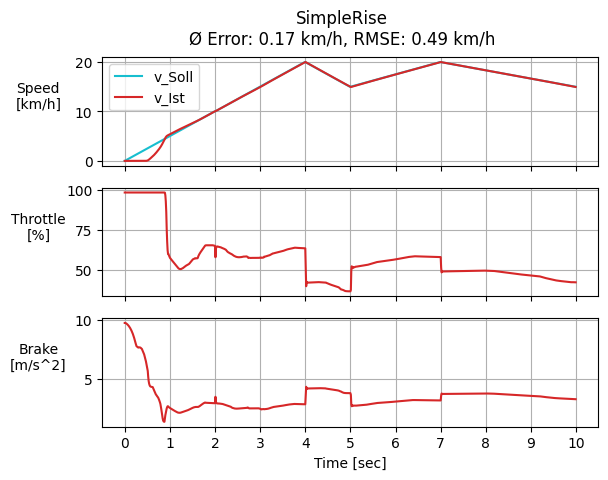

In [8]:
# plot the policy
import pandas as pd
import matplotlib.pyplot as plt

policy_name = r"experiments/simpleCar/simpleAgent_debugged_2/best_model"
model = SAC.load(os.path.join("savedDrivers", policy_name))

maneuver_duration_sec = 10

plot_title = "SimpleRise"

env = simpleDriver()

done = False
obs = env.reset()
rows = []
total_reward = 0
v_soll_all = env.v_Soll_all
actions = np.array([])

while not done:
    action, _ = model.predict(obs, deterministic=True)
    
    obs, reward, done, info = env.step(action)
    rows.append(

    {
        "v_ist": env.v_Car_kmh,
        "DK_Soll": env.throttle,      # DK_Soll and Bremse_S are not unnormalized, this should be fixed
        "Bremse_S": env.brake  
    })
    total_reward += reward
    actions = np.append(actions, action)

all_obs_pd = pd.DataFrame(rows)
v_soll_pd = pd.DataFrame(v_soll_all)

fig, axs = plt.subplots(3, sharex = True)
axs[0].plot(v_soll_pd, label = "v_Soll", markevery=1, color = "tab:cyan")
axs[0].plot(all_obs_pd["v_ist"], label = "v_Ist", markevery = 1, color = "tab:red")

axs[1].plot(all_obs_pd["DK_Soll"], label = "DK_Soll", color = "tab:red")
axs[2].plot(all_obs_pd["Bremse_S"], label = "Bremse_S", color = "tab:red")

axs[0].grid()
axs[1].grid()
axs[2].grid()

axs[0].legend()

axs[2].set_xlabel("Time [sec]")

axs[0].set_ylabel("Speed\n[km/h]", rotation = 0, labelpad = 20)
axs[1].set_ylabel("Throttle\n[%]", rotation = 0, labelpad = 20)
axs[2].set_ylabel("Brake\n[m/s^2]", rotation = 0, labelpad = 20)

axs[2].set_xticklabels(np.arange(-1, maneuver_duration_sec+1))
axs[2].locator_params(axis = "x", nbins = maneuver_duration_sec+1)

deviation_v = round(np.mean(np.absolute(v_soll_all-all_obs_pd["v_ist"])),2)
mse_v = np.mean(np.square(np.absolute(v_soll_all-all_obs_pd["v_ist"])))
rmse_v = round(np.sqrt(mse_v), 2)
fig.suptitle(f"{plot_title}\nØ Error: {deviation_v} km/h, RMSE: {rmse_v} km/h")

fig.align_ylabels()
fig.show()

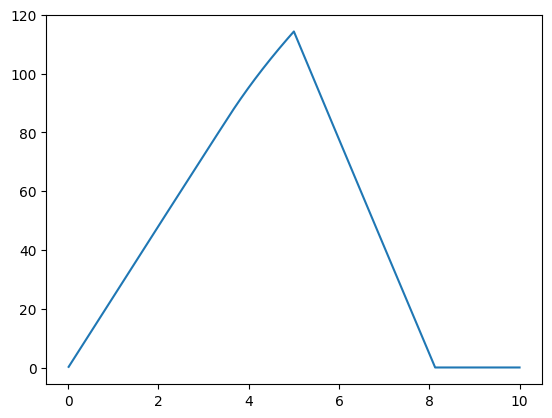

In [9]:
# debugging simplecar (compare to MATLAB results)
import matplotlib.pyplot as plt
import pandas as pd

env = simpleDriver(v_Car_Init=0)
rows = []
steps = 0
time = 10 #s

for i in range(int(time/0.01)):
    if i < int(time/0.01/2):
        throttle = 100 #full throttle, no brake
        brake = 0
    else:
        throttle = 0
        brake = 10
        
    env._Car(throttle=throttle, brake=brake )
    steps = steps + 0.01
    rows.append({
        "v_ist": env.v_Car_kmh,
        "time" : steps
    })

rows_pd = pd.DataFrame(rows)
plt.plot(rows_pd["time"], rows_pd["v_ist"], label="v_ist")
#plt.plot(rows_pd["DK"], label="DK")
#plt.plot(rows_pd["Bremse"], label="Bremse")